This notebook is taken and adapted from the materials attached to: Aurelien Geron, "Hands-On Machine Learning with scikit-learn, keras and tensorflow", 3rd edition

# Setup

This project requires Python 3.7 or above:

In [1]:
import sys

assert sys.version_info >= (3, 7)

And TensorFlow ≥ 2.8:

In [2]:
from packaging import version
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

2024-03-13 19:32:41.362667: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-13 19:32:41.690590: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-13 19:32:41.690793: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-13 19:32:41.743289: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-13 19:32:41.857497: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-13 19:32:41.860598: I tensorflow/core/platform/cpu_feature_guard.cc:1

As we did in earlier chapters, let's define the default font sizes to make the figures prettier. We will also display some Matplotlib animations, and there are several possible options to do that: we will use the Javascript option.

In [3]:
import matplotlib.animation
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('animation', html='jshtml')

Let's install the Gymnasium library, which provides many environments for Reinforcement Learning. We'll also install the extra libraries needed for classic control environments (including CartPole, which we will use shortly), as well as for Box2D and Atari environments, which are needed for the exercises.

In [5]:
!{sys.executable} -m pip install gymnasium swig

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 2.4 MB/s eta 0:00:00 MB/s eta 0:00:01:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 8.2 MB/s eta 0:00:002.6 MB/s eta 0:00:01m


In [13]:
!{sys.executable} -m pip install  "gymnasium[classic_control,box2d,atari,accept-rom-license]"

  Using cached box2d_py-2.3.5-cp39-cp39-linux_x86_64.whl
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 520.8 kB/s eta 0:00:001m483.8 kB/s eta 0:00:01
  Using cached AutoROM.accept_rom_license-0.6.1-py3-none-any.whl
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 9.8 MB/s eta 0:00:000m eta 0:00:010:0101
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 10.2 MB/s eta 0:00:00 MB/s eta 0:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.9/97.9 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 9.0 MB/s eta 0:00:00


# Introduction to Gymnasium

In this notebook we will be using [gymnasium](https://github.com/Farama-Foundation/Gymnasium), a great toolkit for developing and comparing Reinforcement Learning algorithms. It provides many environments for your learning *agents* to interact with. Let's import Gym and make a new CartPole environment:

In [6]:
import gymnasium as gym

env = gym.make("CartPole-v1", render_mode="rgb_array")

The CartPole (version 1) is a very simple environment composed of a cart that can move left or right, and pole placed vertically on top of it. The agent must move the cart left or right to keep the pole upright.

**Tip**: `gym.envs.registry` is a dictionary containing all available environments:

In [7]:
# extra code – shows the first few environments
envs = gym.envs.registry
sorted(envs.keys())[:5] + ["..."]

['Acrobot-v1', 'Ant-v2', 'Ant-v3', 'Ant-v4', 'BipedalWalker-v3', '...']

The registry values are environment specifications:

In [8]:
# extra code – shows the specification for the CartPole-v1 environment
envs["CartPole-v1"]

EnvSpec(id='CartPole-v1', entry_point='gymnasium.envs.classic_control.cartpole:CartPoleEnv', reward_threshold=475.0, nondeterministic=False, max_episode_steps=500, order_enforce=True, autoreset=False, disable_env_checker=False, apply_api_compatibility=False, kwargs={}, namespace=None, name='CartPole', version=1, additional_wrappers=(), vector_entry_point='gymnasium.envs.classic_control.cartpole:CartPoleVectorEnv')

Let's initialize the environment by calling is `reset()` method. This returns an observation, as well as a dictionary that may contain extra information. Both are environment-specific.

In [9]:
obs, info = env.reset(seed=42)
obs

array([ 0.0273956 , -0.00611216,  0.03585979,  0.0197368 ], dtype=float32)

In [10]:
info

{}

In the case of the CartPole, each observation is a 1D NumPy array composed of 4 floats: they represent the cart's horizontal position, its velocity, the angle of the pole (0 = vertical), and the angular velocity.

An environment can be visualized by calling its `render()` method. If you set `render_mode` to `"rgb_array"` when creating the environment, then this will return a NumPy array.

In [14]:
img = env.render()
img.shape  # height, width, channels (3 = Red, Green, Blue)

(400, 600, 3)

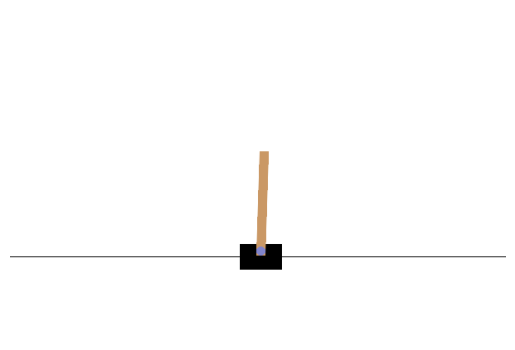

In [15]:
def plot_environment(env):
    img = env.render()
    plt.axis('off')
    plt.imshow(img)
    plt.show()
plot_environment(env)

Let's see how to interact with an environment. Your agent will need to select an action from an "action space" (the set of possible actions). Let's see what this environment's action space looks like:

In [16]:
env.action_space

Discrete(2)

Yep, just two possible actions: accelerate towards the left (0) or towards the right (1).

Since the pole is leaning toward the right (`obs[2] > 0`), let's accelerate the cart toward the right:

In [17]:
action = 1  # accelerate right
obs, reward, done, truncated, info = env.step(action)
obs

array([ 0.02727336,  0.18847767,  0.03625453, -0.26141977], dtype=float32)

Notice that the cart is now moving toward the right (`obs[1] > 0`). The pole is still tilted toward the right (`obs[2] > 0`), but its angular velocity is now negative (`obs[3] < 0`), so it will likely be tilted toward the left after the next step.

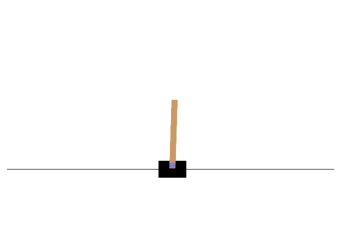

In [15]:
# extra code – displays the environment
plot_environment(env)

Looks like it's doing what we're telling it to do!

The environment also tells the agent how much reward it got during the last step:

In [16]:
reward

1.0

When the game is over, the environment returns `done=True`. In this case, it's not over yet:

In [17]:
done

False

Some environment wrappers may want to interrupt the environment early. For example, when a time limit is reached or when an object goes out of bounds. In this case, `truncated` will be set to `True`. In this case, it's not truncated yet:

In [18]:
truncated

False

For us, we will always finish the episode whenever ``done`` or ``truncated`` are ``True``.

Finally, `info` is an environment-specific dictionary that can provide some extra information that you may find useful for debugging or for training. For example, in some games it may indicate how many lives the agent has.

In [19]:
info

{}

The sequence of steps between the moment the environment is reset until it is done or truncated is called an "episode". At the end of an episode (i.e., when `step()` returns `done=True` or `truncated=True`), you should reset the environment before you continue to use it.

In [18]:
if done or truncated:
    obs, info = env.reset()

Now how can we make the poll remain upright? We will need to define a _policy_ for that. This is the strategy that the agent will use to select an action at each step. It can use all the past actions and observations to decide what to do.

# A simple hard-coded policy

Let's hard code a simple strategy: if the pole is tilting to the left, then push the cart to the left, and _vice versa_. Let's see if that works:

In [19]:
# If the pole is leaning left, move left. Otherwise, move right.
def basic_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1

totals = []
for episode in range(500):
    episode_rewards = 0
    obs, info = env.reset(seed=episode)
    for step in range(200):
        action = basic_policy(obs)
        obs, reward, done, truncated, info = env.step(action)
        episode_rewards += reward
        if done or truncated:
            break

    totals.append(episode_rewards)

In [20]:
import numpy as np

np.mean(totals), np.std(totals), min(totals), max(totals)

(41.698, 8.389445512070509, 24.0, 63.0)

Well, as expected, this strategy is a bit too basic: the best it did was to keep the poll up for only 63 steps. This environment is considered solved when the agent keeps the poll up for 200 steps.

Let's visualize one episode. You can learn more about Matplotlib animations in other chapters of the book.

In [21]:
# extra code – this cell displays an animation of one episode

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = matplotlib.animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

def show_one_episode(policy, n_max_steps=200, seed=None):
    env = gym.make("CartPole-v1", render_mode="rgb_array")
    np.random.seed(seed)
    if seed == None:
        obs, info = env.reset()
    else:
        obs, info = env.reset(seed=seed)
    frames = [env.render()]
    total_reward = 0
    for step in range(n_max_steps):
        action = policy(obs)
        obs, reward, done, truncated, info = env.step(action)
        frames.append(env.render())
        total_reward += reward
        if done or truncated:
            break
    print('Environment at closing:', obs, reward, done, truncated, info)
    env.close()
    print('Total reward %lf.0' % total_reward)
    return plot_animation(frames)

show_one_episode(basic_policy)

Environment at closing: [-0.18438654 -0.4367234   0.21760178  0.670552  ] 1.0 True False {}
Total reward 34.000000.0


Clearly the system is unstable and after just a few wobbles, the pole ends up too tilted: game over. We will need to be smarter than that!

# Exercise: Neural Network Policy

Let's create a neural network that will take observations as inputs, and output the probabilities of actions to take for each observation. To choose an action, the network will estimate a probability for each action, then we will select an action randomly according to the estimated probabilities. In the case of the CartPole environment, there are just two possible actions (left or right), so we only need one output neuron: it will output the probability `p` of the action 0 (left), and of course the probability of action 1 (right) will be `1 - p`.

In [90]:
np.random.uniform()

0.30085287955541296

In [25]:
# Exercise: Write code that implements in keras a randomly initialized neural network policy.
# Run your policy to see the results.
# Architecture recommendation: One layer with ReLU activations and one sigmoid output neuron.
model= tf.keras.Sequential([
    tf.keras.layers.Dense(5, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(1,activation=tf.keras.activations.sigmoid)
])
def pg_policy(obs):
    d=model.predict(obs[np.newaxis])
    d = d[0][0]
    if np.random.uniform() <= d:
        return 1
    else:
        return 0
    
    
show_one_episode(pg_policy, n_max_steps=200, seed=None)

1/1 [==============================] - 0s 10ms/step
Environment at closing: [ 0.10817257  1.3921137  -0.21208602 -2.182321  ] 1.0 True False {}
Total reward 9.000000.0


In [23]:
def play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        left_proba = model(obs[np.newaxis])[0][0]
        action = 1 if np.random.uniform() > left_proba else 0
        y_target = tf.constant([1-action], dtype=tf.float32)
        loss = loss_fn(y_target, left_proba)

    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, done, truncated, info = env.step(action)
    return obs, reward, done or truncated, grads

In [26]:
obs , info = env.reset()
loss_fn = tf.keras.losses.binary_crossentropy
obs, reward, finished, grads = play_one_step(
                env, obs, model, loss_fn)

In [28]:
reward

1.0

In [29]:
def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs, info = env.reset()
        for step in range(n_max_steps):
            obs, reward, finished, grads = play_one_step(
                env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if finished:
                break

        all_rewards.append(current_rewards)
        all_grads.append(current_grads)

    return all_rewards, all_grads

In [36]:
R, G = play_multiple_episodes(env, 3,10, model, loss_fn)

In [37]:
R

[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]

In [46]:
G[0][0][0][0][0:]

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([-0.        , -0.        ,  0.00933172, -0.        ,  0.        ],
      dtype=float32)>